# Calibration Standards

Some simple median-filtered plots of DESI calibrations from arc lamps and LED flat exposures. Plotting code is recycled from Daniel Eisenstein's [DQS notebooks](https://desi.lbl.gov/trac/wiki/DESIOperations/DQSAuxillaryTools).

In [1]:
import os
import re
import fitsio
import numpy as np
from scipy import ndimage
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=14)

In [3]:
nightwatch_dir = '/global/cfs/cdirs/desi/spectro/nightwatch/kpno'
night = 20220207

## Utility Function to Access Calibration Exposures

Get a list of calibration exposures from a given reduction folder and a given night. Returns a dictionary of exposure numbers from that night, keyed by calibration program type.

In [4]:
def get_cal_exposures(redux_dir, night):
    """Return a list of calibration exposures from a given reduction and date.
    
    Parameters
    ----------
    redux_dir: str
        Path to qframe data reductions.
    night : str
        YYYYMMDD date string.
    
    Returns
    -------
    cal_exposures : dict
        
    """
    exp_dirs = sorted(glob(f'{redux_dir}/{night}/*'))
    exposures = [os.path.basename(_) for _ in exp_dirs if re.match('.*\d{8}$', _.strip())]
    cal_exposures = {}
    for exposure in exposures:
        qframes = sorted(glob(f'{redux_dir}/{night}/{exposure}/qframe-*.fits'))
        if qframes:
            hdr = fitsio.read_header(qframes[0], 'FLUX')
            prog = hdr['PROGRAM']
            if prog.startswith('CALIB') or prog.startswith('LED'):
                if prog in cal_exposures:
                    cal_exposures[prog].append(exposure)
                else:
                    cal_exposures[prog] = [exposure]
                
    return cal_exposures

In [5]:
cal_exps = get_cal_exposures(nightwatch_dir, night)

In [6]:
cal_exps

{'CALIB short Arcs all': ['00121658',
  '00121659',
  '00121660',
  '00121661',
  '00121662'],
 'CALIB long Arcs Cd+Xe': ['00121665',
  '00121666',
  '00121667',
  '00121668',
  '00121669'],
 'CALIB DESI-CALIB-00 LEDs only': ['00121674', '00121675', '00121676'],
 'CALIB DESI-CALIB-01 LEDs only': ['00121679', '00121680', '00121681'],
 'CALIB DESI-CALIB-02 LEDs only': ['00121684', '00121685', '00121686'],
 'CALIB DESI-CALIB-03 LEDs only': ['00121689', '00121690', '00121691'],
 'LED03 flat for CTE check': ['00121692']}

## Plotting Function for Calibration Spectra

Median-filter the spectra from about 20 fibers per camera. This is taken directly from the Eisenstein notebooks.

In [7]:
def median_spectrum(reduxdir, night, exposure, cam, mincounts):
    directory = reduxdir+'/'+f'{night}'+'/'+f'{exposure}'
    fname = directory+'/qframe-'+cam+'*.fits'
    specfiles = sorted(glob(fname))
    if (len(specfiles)==0):
        print("No qframe files found matching", fname)
        raise RuntimeError('No file found')
    #print(specfiles[0])
    specobj = fitsio.FITS(specfiles[0])
    image = specobj["FLUX"].read()  #[band][0:500]
    wave  = specobj["WAVELENGTH"].read()
    median0 = np.median(image[230:250,:],axis=0)
    median1 = np.median(image[250:270,:],axis=0)
    wave = np.median(wave[230:270,:],axis=0)
    median0min = np.where(median0>mincounts, median0, mincounts)
    median1min = np.where(median1>mincounts, median1, mincounts)
    median0 = np.where(median0!=0, median0, 1e-3)
    median1 = np.where(median1!=0, median1, 1e-3)

    return median0min, median1min, median0, median1, wave

### Test Plot: Distribution of Spectra from One Night

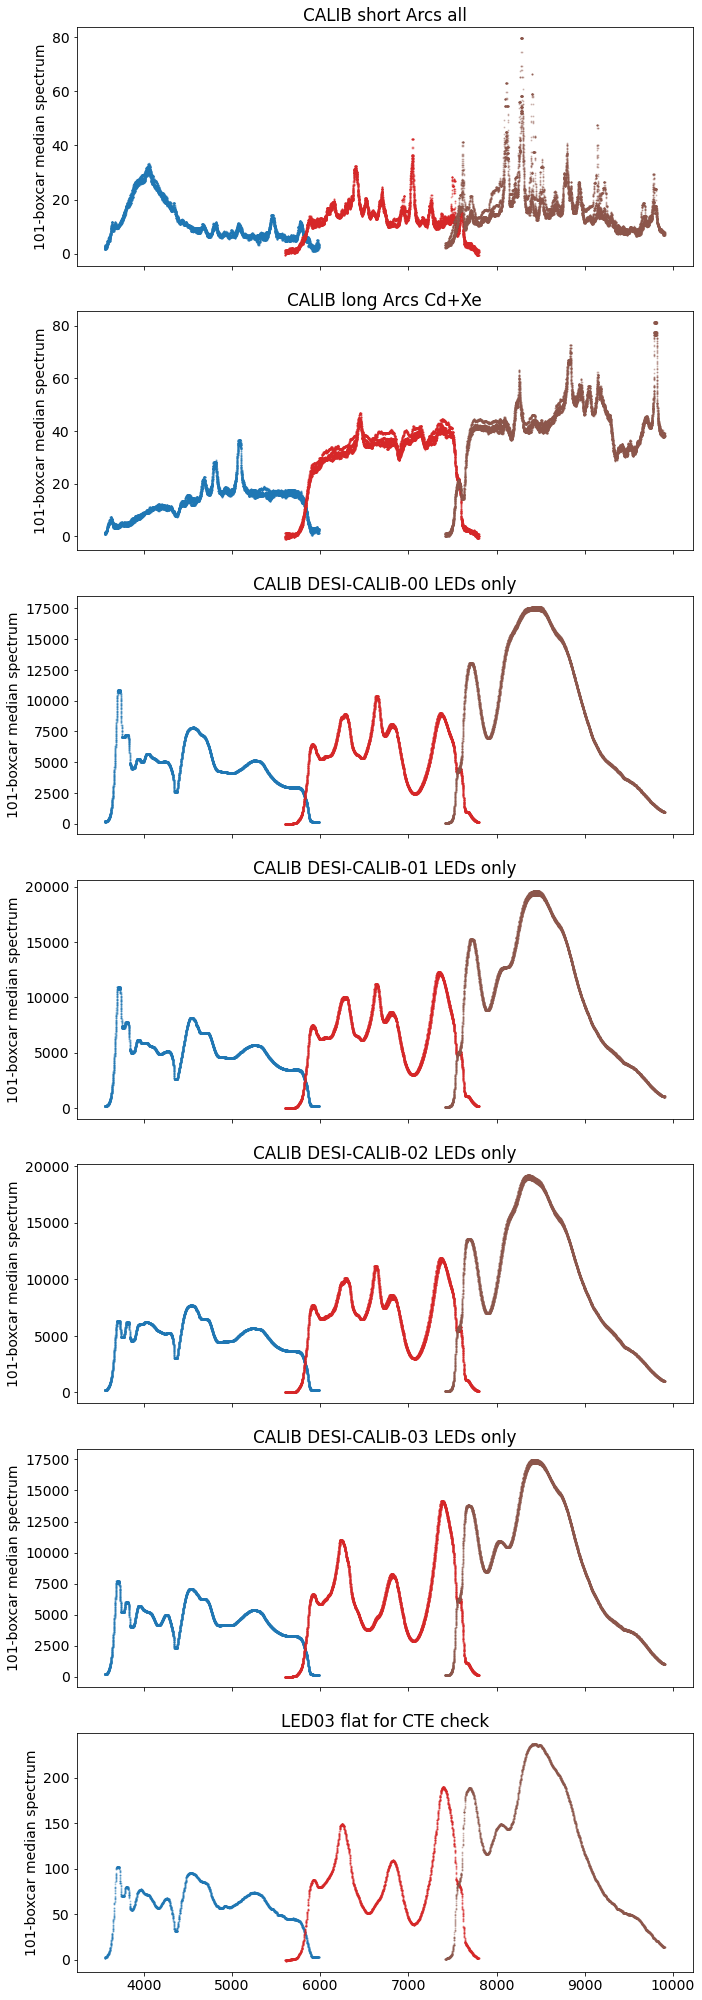

In [8]:
smooth = 5
continuum = 101
delta = 1.5

colors = { 'b':'C0', 'r':'C3', 'z':'C5' }

ncals = len(cal_exps)
fig, axes = plt.subplots(ncals, 1, figsize=(10,4*ncals), sharex=True, tight_layout=True)

for i, caltype in enumerate(cal_exps.keys()):
    ax = axes[i]
    ax.set(ylabel='101-boxcar median spectrum',
           title=caltype)
    
    for c in 'brz':
        for cal_exp in cal_exps[caltype]:
            m0min, m1min, m0, m1, wave = median_spectrum(nightwatch_dir, night, cal_exp, f'{c}0', 100)
            m0min = ndimage.uniform_filter1d(m0min, smooth)  # A running averaging
            m1min = ndimage.uniform_filter1d(m1min, smooth) 
            m0 = ndimage.median_filter(m0, continuum)  # A running median, for the continuum
            m1 = ndimage.median_filter(m1, continuum) 

            ax.scatter(wave, m1, s=1, c=colors[c], alpha=0.3)

### Test Plot: Distribution of Spectra from Feb. 2022

This should show relatively stable spectra from end of January/start of February 2022.

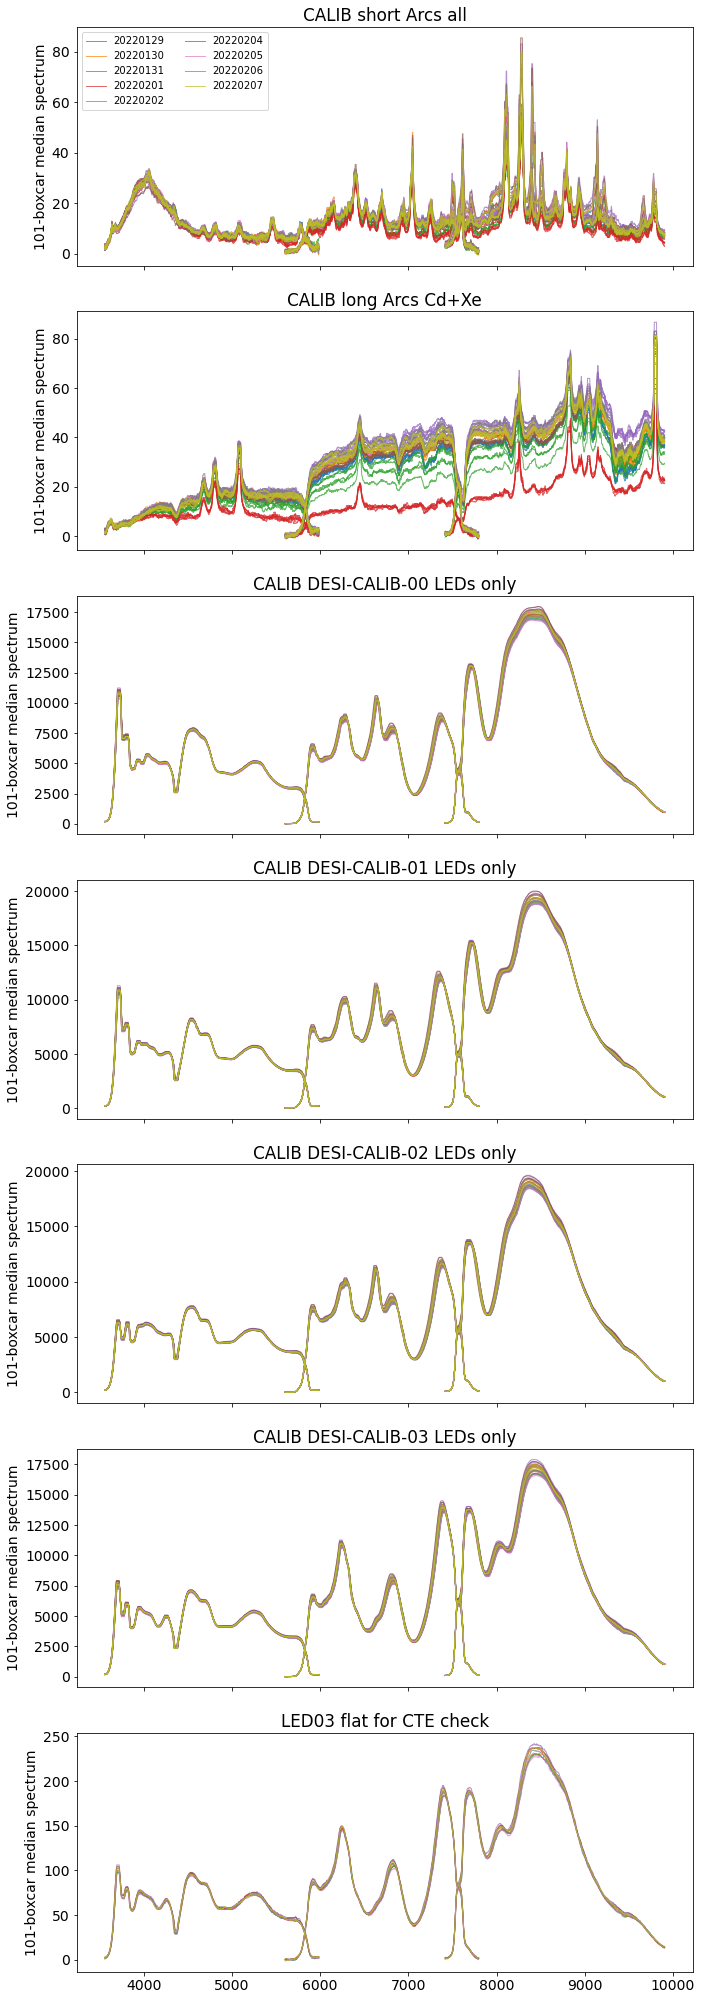

In [9]:
smooth = 5
continuum = 101
delta = 1.5

colors = { 'b':'C0', 'r':'C3', 'z':'C5' }

ncals = 7 #len(cal_exps)
fig, axes = plt.subplots(ncals, 1, figsize=(10,4*ncals), sharex=True, tight_layout=True)

mlast = ncals*[[[], [], []]]

for i, night in enumerate([20220129, 20220130, 20220131, 20220201, 20220202, 20220204, 20220205, 20220206, 20220207]):
    cal_exps = get_cal_exposures(nightwatch_dir, night)

    for j, caltype in enumerate(cal_exps.keys()):
        ax = axes[j]
        ax.set(ylabel='101-boxcar median spectrum',
               title=caltype)

        for c in 'brz':
            for k, cal_exp in enumerate(cal_exps[caltype]):
                m0min, m1min, m0, m1, wave = median_spectrum(nightwatch_dir, night, cal_exp, f'{c}0', 100)
                m0min = ndimage.uniform_filter1d(m0min, smooth)  # A running averaging
                m1min = ndimage.uniform_filter1d(m1min, smooth) 
                m0 = ndimage.median_filter(m0, continuum)  # A running median, for the continuum
                m1 = ndimage.median_filter(m1, continuum)

                if j==0 and k==0 and c=='b':
                    ax.plot(wave, m1, lw=1, c=f'C{i}', alpha=0.7, label=night)
                else:
                    ax.plot(wave, m1, lw=1, c=f'C{i}', alpha=0.7)

axes[0].legend(loc='upper left', fontsize=10, ncol=2)

### Test Plot: Stray Light

These are data from Sep. 2021 showing one night (20210922) with significant stray light in the afternoon calibrations. The OA discovered after completing the cal sequences that the dome truck rail lights were left on after dome work at the 4m. The stray light can be observed as a significant excess in the continuum above 6500A.

The goal of the reference standard will be to automatically catch this kind of issue in real time.

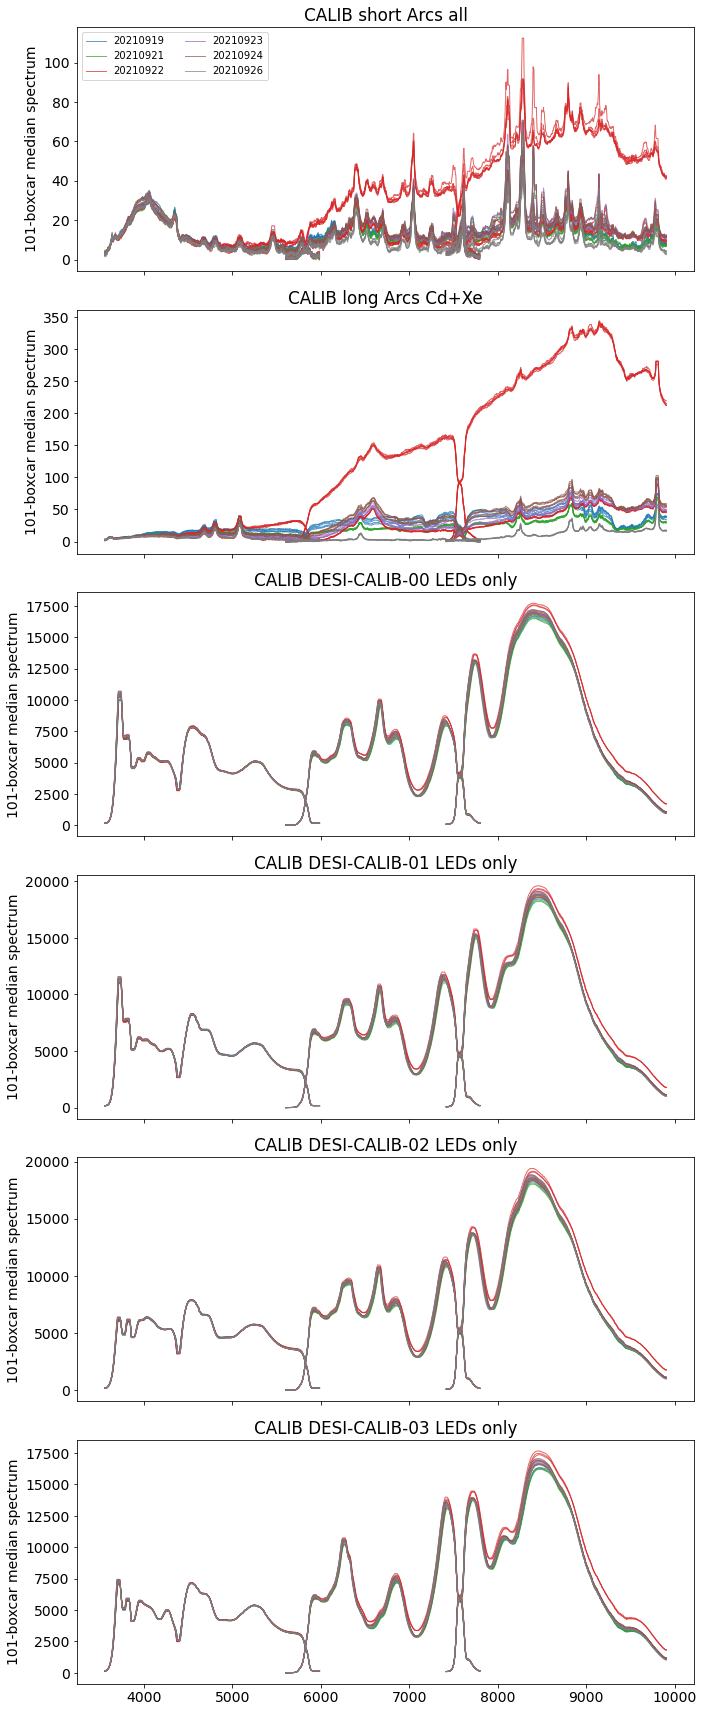

In [10]:
smooth = 5
continuum = 101
delta = 1.5

colors = { 'b':'C0', 'r':'C3', 'z':'C5' }

ncals = 6 #len(cal_exps)
fig, axes = plt.subplots(ncals, 1, figsize=(10,4*ncals), sharex=True, tight_layout=True)

mlast = ncals*[[[], [], []]]

for i, night in enumerate([20210919, 20210920, 20210921, 20210922, 20210923, 20210924, 20210925, 20210926]):
    cal_exps = get_cal_exposures(nightwatch_dir, night)

    for j, caltype in enumerate(cal_exps.keys()):
        ax = axes[j]
        ax.set(ylabel='101-boxcar median spectrum',
               title=caltype)

        for c in 'brz':
            for k, cal_exp in enumerate(cal_exps[caltype]):
                m0min, m1min, m0, m1, wave = median_spectrum(nightwatch_dir, night, cal_exp, f'{c}0', 100)
                m0min = ndimage.uniform_filter1d(m0min, smooth)  # A running averaging
                m1min = ndimage.uniform_filter1d(m1min, smooth) 
                m0 = ndimage.median_filter(m0, continuum)  # A running median, for the continuum
                m1 = ndimage.median_filter(m1, continuum)

                if j==0 and k==0 and c=='b':
                    ax.plot(wave, m1, lw=1, c=f'C{i}', alpha=0.7, label=night)
                else:
                    ax.plot(wave, m1, lw=1, c=f'C{i}', alpha=0.7)

axes[0].legend(loc='upper left', fontsize=10, ncol=2)
fig.savefig('desicals_202109_straylight.png')